# The Battle of the Neighborhoods - São Paulo - Brazil
### Applied Data Science Capstone

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Currently, in the consumption of pizza, the city of São Paulo only loses to New York, where it competes fiercely for the title of world capital of pizza.

This project aims to find the best place to open a **Pizza Place** in the city of **São Paulo**.

Since there are so many pizza places in town, let's use data science to understand the best locations for a new pizza place. Based on the main central neighborhoods of São Paulo, we will try to detect the number of existing pizzerias, categorize them in nearby groups and based on the number of inhabitants of the region, define which are the best places to be chosen by the interested parties to the new emprendiment.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing pizza centers in the neighborhood
* number of inhabitants in the neighborhood
* pizzeria density in determined clusters

Following data sources will be needed to extract/generate the required information:
* will be necessary to create a database containing the neighborhoods, their geolocation and habitation data using sources of IBGE institute.
* number of pizza places and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of São Paulo center will be obtained using **Google Maps**

### Preparing the Data
___

* Import Libraries, Credential Definitions and create functions

In [1]:
import folium 
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
### Define Foursquare Credentials and Version
CLIENT_ID = 'M0V3GQAG4NFCPEOSCT4LZBTYB1DASQ1K0CKQRO1TATNKL5BY'
CLIENT_SECRET = '0VSA2NQ1DX22ZO3XFWPVRBWZEE3PE0ARZWTNFKED1OLLGDU3' 
VERSION = '20180604'

# Limit of number of venues returned by Foursquare API
LIMIT = 100 
# Define radius of search for Foursquare API
radius = 10000

In [3]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
# Function to get Nearby Venues
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [5]:
# Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

* Import location and population data from princials Districts

    This Data has ben downloaded and complilated from <b>IBGE Institute</b>

In [6]:
df_districs = pd.read_excel('C:/Users/girot/Desktop/Data Science/9.Applied Data Science Capstone/Week 4 - The Battle of Neighborhoods/Districts - São Paulo - Brazil.xls')
#lat_lng.rename(columns={'Postal Code':'Postcode'},inplace=True)
df_districs.head()

,DISTRICT,LATITUDE,LONGITUDE,POPULATION
0,SE,-23.550422,-46.634279,23651
1,TUCURUVI,-23.474080,-46.610671,98438
2,PINHEIROS,-23.562083,-46.694794,65364
3,MOOCA,-23.563591,-46.596829,75724
4,ITAIM BIBI,-23.585460,-46.671726,92570


* Import Data of Venues from <b><i>Foursquare</i></b>
    

In [7]:
df_venues = getNearbyVenues(names=df_districs['DISTRICT'],
                                latitudes=df_districs['LATITUDE'],
                                longitudes=df_districs['LONGITUDE']
                                )
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SE,-23.550422,-46.634279,Casa de Francisca,-23.548733,-46.634763,Music Venue
1,SE,-23.550422,-46.634279,Caixa Cultural,-23.549381,-46.632849,Art Gallery
2,SE,-23.550422,-46.634279,Kopenhagen,-23.551759,-46.635370,Chocolate Shop
3,SE,-23.550422,-46.634279,Centro Cultural Banco do Brasil (CCBB),-23.547588,-46.634683,Cultural Center
4,SE,-23.550422,-46.634279,Teatro CCBB,-23.547644,-46.634733,Theater


In [8]:
# create map
sao_paulo_latitude = -23.5489
sao_paulo_longitude = -46.6388
map_clusters = folium.Map(location=[sao_paulo_latitude, sao_paulo_longitude], zoom_start=11)

# Add markers to the map
markers_colors = []
for lat, lon in zip(df_venues['Venue Latitude'], 
                    df_venues['Venue Longitude']
                                  ):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
       fill_opacity=0.7).add_to(map_clusters)

map_clusters

* Creating a DataFrame with only <b>pizza places</b>

In [9]:
df_pizza_places = df_venues[df_venues['Venue Category'].str.contains('Pizza')]
df_bars = df_venues[df_venues['Venue Category'].str.contains('Bar')]

In [10]:
print('Principal DataFrames:')
print('Df_Districs: ', df_districs.shape)
print('df_venues: ', df_venues.shape)
print('df_pizza_places: ', df_pizza_places.shape)
print('df_bars: ', df_bars.shape)

Principal DataFrames:
Df_Districs:  (24, 4)
df_venues:  (2392, 7)
df_pizza_places:  (94, 7)
df_bars:  (145, 7)


## Methodology <a name="methodology"></a>

With the objective of opening a new pizzeria in São Paulo, this project seeks to understand the best location for the new venture.

First we will collect data from the main neighborhoods of São Paulo such as location and population data. We found such data at the IBGE Institute.
It was also necessary to collect the location of the existing pizzerias, for these we use Foursquare

The next step will be to identify if exist a correlation with the number of pizzerias and the number of people living in a particular neighborhood

Let's create a map where pizzerias are organized into clusters (using K-means) and we verified the proportion of that with the number of inhabitants of the neighborhoods that are part of the given cluster

This gives us a good idea of where the ideal place to open a new pizzeria would be.

## Analysis <a name="analysis"></a>

Let's start with some basic analysis. First let's join the table with the information of inhabitants of the neighborhood with the data of foursquare and verify the correlation between inhabitants and the number of population of the region.

(0, 11.507472668979291)

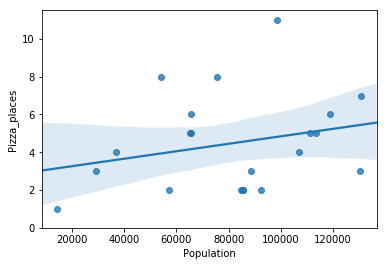

In [62]:
#Create the db to join the population data
df_join = df_districs[['DISTRICT','POPULATION']]
df_join.rename(columns={'DISTRICT':'Neighborhood','POPULATION':'Population'},  inplace=True)
#df_join.head()

#Join population data on the df of pizza places
df_correlation = df_pizza_places[['Neighborhood','Venue']]
df_group = df_correlation.groupby('Neighborhood').count()
df_corr = df_group.join(df_join.set_index('Neighborhood'), on='Neighborhood').reset_index()
df_corr.rename(columns={'Venue':'Pizza_places'},  inplace=True)
#df_corr

sns.regplot(x="Population", y="Pizza_places", data=df_corr)
plt.ylim(0,)

As we can see from the graph, the correlation between the data is low. But this also tells us that we have opportunities in some neighborhoods...

...So let's see which neighborhood has the most opportunities according to the number of pizzerias per inhabitant

simply dividing the total population by the number of pizzerias in a particular neighborhood.

In [12]:
df_corr['DivPop'] = df_corr['Population'] / df_corr['Pizza_places']
df_corr['DivPop'] = pd.to_numeric(df_corr['DivPop'])
df_corr.sort_values(['DivPop'], ascending=False).head()

,Neighborhood,Pizza_places,Population,DivPop
9,ITAIM BIBI,2,92570,46285.000000
19,VILA MARIA,3,130484,43494.666667
17,VILA BANDEIRANTES,2,85624,42812.000000
5,CASA VERDE,2,85624,42812.000000
1,AGUA BRANCA,2,84963,42481.500000


Initially <b>Itaim Bibi, Vila Maria and Vila bandeirantes </b> are the 3 neighborhoods with the greatest opportunity. But if we create there are many pizzerias in the surrounding neighborhoods?


To check the disposition of the other pizzerias, let's create clusters to facilitate the analysis. For that we will use <b>K-means</b>

<h3><font color = 'Green'> K-Means </font>

First let's adjust the data

In [63]:
df_locations = df_pizza_places[['Venue Latitude','Venue Longitude']]
df_locations.rename(columns={'Venue Latitude':'Latitude','Venue Longitude':'Longitude'},  inplace=True)
df_locations.head()

,Latitude,Longitude
110,-23.471773,-46.617610
113,-23.476934,-46.605993
117,-23.472292,-46.606902
120,-23.481483,-46.617891
132,-23.483593,-46.618981


Let's run K-means creating 7 Clusters

In [14]:
# Set number of clusters
kclusters = 7

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_locations)

# check cluster labels generated for each row in the dataframe
categories_merged = df_pizza_places.copy()
categories_merged['Cluster_Labels'] = kmeans.labels_
categories_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster_Labels
110,TUCURUVI,-23.47408,-46.610671,Arcos da Cantareira,-23.471773,-46.617610,Pizza Place,0
113,TUCURUVI,-23.47408,-46.610671,Costa & Costa pizzaria,-23.476934,-46.605993,Pizza Place,0
117,TUCURUVI,-23.47408,-46.610671,Don Fradicio Pizzeria,-23.472292,-46.606902,Pizza Place,0
120,TUCURUVI,-23.47408,-46.610671,Meime Pizzaria,-23.481483,-46.617891,Pizza Place,0
132,TUCURUVI,-23.47408,-46.610671,Pizza & Pizzas,-23.483593,-46.618981,Pizza Place,0


In [64]:
# create map
sao_paulo_latitude = -23.5489
sao_paulo_longitude = -46.6388
map_clusters = folium.Map(location=[sao_paulo_latitude, sao_paulo_longitude], zoom_start=11)
#map_clusters

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(categories_merged['Venue Latitude'], 
                                  categories_merged['Venue Longitude'], 
                                  categories_merged['Neighborhood'], 
                                  categories_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

Great, now let's look at each cluster. For this we will need to check which neighborhoods are associated with each cluster and gather the population information

In [16]:
categories_merged.groupby('Cluster_Labels').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Cluster_Labels,,,,,,,
0,11,11,11,11,11,11,11
1,15,15,15,15,15,15,15
2,20,20,20,20,20,20,20
3,14,14,14,14,14,14,14
4,12,12,12,12,12,12,12
5,12,12,12,12,12,12,12
6,10,10,10,10,10,10,10


In [17]:
clusters_neig = categories_merged[['Neighborhood','Cluster_Labels', 'Venue']]
df_cluster = clusters_neig.groupby(['Neighborhood', 'Cluster_Labels']).count()
df_cluster = df_cluster.reset_index()

In [18]:
df_cluster = df_cluster.drop(9, 0)
df_cluster = df_cluster.drop(17, 0)

Add population data to DF

In [19]:
df_cluster_join = df_cluster.join(df_join.set_index('Neighborhood'), on='Neighborhood')
df_cluster_join.drop(['Neighborhood'], axis = 1,inplace=True)
df_cluster_join = df_cluster_join.groupby('Cluster_Labels').sum()
df_cluster_join.rename(columns={'Venue':'Pizza_places'},  inplace=True)

Calculating the indicator

In [20]:
df_cluster_join['divpop'] = df_cluster_join['Population'] / df_cluster_join['Pizza_places']
df_cluster_join['divpop'] = pd.to_numeric(df_cluster_join['divpop'])
df_cluster_join = df_cluster_join.sort_values(['divpop'], ascending=False)
df_cluster_join = df_cluster_join.reset_index()
df_cluster_join

,Cluster_Labels,Pizza_places,Population,divpop
0,6,5,185631,37126.200000
1,4,12,303612,25301.000000
2,1,15,345968,23064.533333
3,3,14,289102,20650.142857
4,2,20,384592,19229.600000
5,5,11,104989,9544.454545
6,0,11,98438,8948.909091


In [25]:
resumo = categories_merged[categories_merged['Cluster_Labels'] == 6]
#df_pizza_places = df_venues[df_venues['Venue Category'].str.contains('Pizza')]
resumo['Neighborhood'].unique()

array(['SANTA IFIGENIA', 'CASA VERDE', 'SANTANA', 'VILA BANDEIRANTES'],
      dtype=object)

The Best cluster is the 6 and the neighborhoods into this cluster are <b> SANTA IFIGENIA, CASA VERDE, SANTANA, VILA BANDEIRANTES</b>

Now, let's creating a map to see bether the locations

In [65]:
# create map
sao_paulo_latitude = -23.5489
sao_paulo_longitude = -46.6388
map_clusters = folium.Map(location=[sao_paulo_latitude, sao_paulo_longitude], zoom_start=12)
#map_clusters

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


folium.CircleMarker(
          [-23.498550, -46.646129],
            radius=20, # define how big you want the circle markers to be
           fill=True,
            fill_color='blue',
            fill_opacity=0.2
        ).add_to(map_clusters)

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(categories_merged['Venue Latitude'], 
                                  categories_merged['Venue Longitude'], 
                                  categories_merged['Neighborhood'], 
                                  categories_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [66]:
sao_paulo_latitude = -23.498550
sao_paulo_longitude = -46.646129
map_clusters = folium.Map(location=[sao_paulo_latitude, sao_paulo_longitude], zoom_start=13)

folium.features.CircleMarker(
          [-23.498550, -46.646129],
            radius=90, # define how big you want the circle markers to be
           fill=True,
            fill_color='blue',
            fill_opacity=0.2
        ).add_to(map_clusters)
map_clusters

This concludes our analysis.

## Results and Discussion <a name="results"></a>

In our analysis we raised the pizzerias in the main neighborhood around the center of Sao Paulo. There are over 90 pizzerias in 20 neighborhoods

We can observe that we have some places with very few restaurants or pizzerias, but also those areas with low population, because they are commercial center.

The focus of this project was to find gaps between clusters where we can have opportunities to install a pizzeria and reach the largest possible

## Conclusion <a name="conclusion"></a>

At the beginning of the analysis we can see that neighborhoods like Itaim Bibi would be an opportunity. But analyzing graphically on a map we can see that we have other regions with greater potential


From the moment the cluesters were created and then estimated the population inserted in each one, it was possible to create the necessary analyzes to then <b>suggest a zone</b>, which will be the starting point for the stakeholders to check more carefully in which exact location open the pizzeria.